## Learning the Distance Function

In [ ]:
!pip install mrcfile absl-py astor cachetools gast h5py opt-einsum pyasn1 pyasn1-modules tensorflow-graphics ipyvolume umap-learn -qq

     |████████████████████████████████| 42 kB 1.4 MB/s 
     |████████████████████████████████| 4.3 MB 8.8 MB/s 
     |████████████████████████████████| 2.9 MB 51.4 MB/s 
     |████████████████████████████████| 88 kB 6.2 MB/s 
     |████████████████████████████████| 1.1 MB 59.3 MB/s 
     |████████████████████████████████| 281 kB 74.8 MB/s 
     |████████████████████████████████| 652 kB 51.7 MB/s 
     |████████████████████████████████| 260 kB 49.7 MB/s 
     |████████████████████████████████| 3.4 MB 51.2 MB/s 
     |████████████████████████████████| 271 kB 55.6 MB/s 
     |████████████████████████████████| 1.1 MB 51.2 MB/s 


In [ ]:
!pip install --upgrade-strategy=only-if-needed tensorflow_similarity[tensorflow] -qq

     |████████████████████████████████| 206 kB 5.2 MB/s 
     |████████████████████████████████| 13.5 MB 63.0 MB/s 
     |████████████████████████████████| 4.3 MB 53.7 MB/s 
     |████████████████████████████████| 188 kB 71.3 MB/s 


In [ ]:
!pip install wandb -qq

     |████████████████████████████████| 1.8 MB 8.4 MB/s 
     |████████████████████████████████| 181 kB 44.2 MB/s 
     |████████████████████████████████| 153 kB 48.4 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!gdown 1--tYrS4MoL3XDU9M6Ie8wzZ1XZ5FWvU1

Downloading...
From: https://drive.google.com/uc?id=1--tYrS4MoL3XDU9M6Ie8wzZ1XZ5FWvU1
To: /content/protein_data_128.zip
100% 612M/612M [00:06<00:00, 101MB/s]


In [ ]:
!unzip protein_data_128.zip

Archive:  protein_data_128.zip
  inflating: indices.npz             
  inflating: mrc.py                  
  inflating: utils_ascep.py          
  inflating: 70S_ctf_128.mrcs        
  inflating: 70S_ctf_128.star        
  inflating: X_ctf.npy               
  inflating: y_ctf.npy               


In [ ]:
ROOT_DIR = '/content/drive/MyDrive/protein-reconstruction/'

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from numba import cuda
import math
cuda.select_device(0)
cuda.close()
import os
import h5py
import math
import numpy as np   
import matplotlib.pyplot as plt
import sys
import pandas as pd
import wandb
sys.path.append(ROOT_DIR) 
from tensorflow.keras.utils import plot_model
from cryoem.conversions import euler2quaternion, d_q, SO3_to_s2s2, s2s2_to_SO3, matrix2quaternion, euler2matrix
from cryoem.plots import plot_projection, plot_dP_dQ
from cryoem.helpers import train_val_test_split, projections_preprocessing, OneCycleLr
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import callbacks
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7880068808959027869
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16139419648
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12534541912693075019
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]


In [ ]:
def visualise_images(X, n_images, n_columns, randomise=True):
    indices = np.arange(X.shape[0])
    if randomise:
        np.random.shuffle(indices)
    indices = indices[:n_images]
    cmap = plt.cm.Greys_r
    n_rows = np.ceil(n_images / n_columns)
    fig = plt.figure(figsize=(2*n_columns, 2*n_rows))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    # plot the digits: each image is 8x8 pixels
    for i, e in enumerate(indices):
        ax = fig.add_subplot(n_rows, n_columns, i + 1, xticks=[], yticks=[])
        ax.imshow(X[e], cmap=cmap, interpolation='nearest')

In [ ]:
from utils_ascep import visualise_images, Starfile, parse_pose_star, plot_euler, parse_ctf_star,plot_ctf, plot_defocus
import mrcfile

### Read data

In [ ]:
wandb.login()

wandb: Currently logged in as: phonchi. Use `wandb login --relogin` to force relogin


True

In [ ]:
configs = dict(
    X_file = "X_ctf.npy",
    y_file = "y_ctf.npy",
    image_width = 128,
    image_height = 128,
    batch_size = 256,
    model_name = 'vgg_like',
    epochs = 50,
    learning_rate = 0.001,
    lr_schedule = '1cycle',
    optimizer = 'adam',
    L2_reg = 0.001,
    Drop_rate = 0.3,
    Sampler = 'random',
    Sample_percent = 0.01,
    BlurLayer = True,
    loss_fn = 'S2S2_MAE',
)

In [ ]:
# Initialize the W&B run
from wandb.keras import WandbCallback
run = wandb.init(project='vgg_direct', config=configs, job_type='train')
config = wandb.config

In [ ]:
config

{'X_file': 'X_ctf.npy', 'y_file': 'y_ctf.npy', 'image_width': 128, 'image_height': 128, 'batch_size': 256, 'model_name': 'vgg_like', 'epochs': 50, 'learning_rate': 0.001, 'lr_schedule': '1cycle', 'optimizer': 'adam', 'L2_reg': 0.001, 'Drop_rate': 0.3, 'Sampler': 'random', 'Sample_percent': 0.01, 'BlurLayer': True, 'loss_fn': 'S2S2_MAE'}

In [ ]:
X = np.load(config.X_file)
y = np.load(config.y_file)

In [ ]:
y = euler2matrix(y)
y = y.numpy()

In [ ]:
train_idx, val_idx, test_idx = train_val_test_split(indices=range(X.shape[0]), file_name="indices.npz")

In [ ]:
len(train_idx), len(val_idx), len(test_idx)

(2512, 838, 1650)

In [ ]:
X.shape, y.shape

((5000, 128, 128, 1), (5000, 3, 3))

In [ ]:
visualise_images(X.squeeze(), 50 , 10, False)

### Testing

#### Data_loader

In [ ]:
from tensorflow.keras.utils import Sequence
import itertools

num_dec = 1
num_bins = 32

class DataGenerator_SO3(Sequence):
    """Custom datsaet generator used to create data for training of distance learning algorithm"""
    def __init__(self, X, y, list_ids, limit_num_pairs=None, limit_style="random", batch_size=256, shuffle=True):
        start_time = time()
        if batch_size > limit_num_pairs:
            raise Exception("Please specify limit_num_pairs that is much higher than batch_size")
        self.X = X  
        self.y = y  
        self.limit_num_pairs = limit_num_pairs
        self.list_ids = list_ids
        self.batch_size = batch_size  
        # all the possible combinations of 2 image id pairs
        self.pair_ids = np.array(list(zip(*list(map(lambda x: x.flatten(), np.meshgrid(list_ids, list_ids))))))  # e.g. train_idx
        
        # Don't use all possible combination of pairs, limit them here
        if self.limit_num_pairs:
            limited_pair_indices = np.random.choice(np.arange(len(self.pair_ids)), size=self.limit_num_pairs)
            self.pair_ids = self.pair_ids[limited_pair_indices]   
        
        if limit_style=="random":
            b = np.array([list_ids,list_ids]).T      
            self.pair_ids = np.concatenate((b,self.pair_ids))
            
        
        if limit_style=="uniform":
            self.pair_ids = self._generate_uniform()
            #b = np.array([list_ids,list_ids]).T
            #self.pair_ids = np.concatenate((b,self.pair_ids))
      
        self.shuffle = shuffle 
        self._on_epoch_start()
        print(f"Data created in {time()-start_time} sec")
        
    def closest(self, lst, K):
      
        return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]      
    
    def _generate_uniform(self):
        if os.path.exists(f"70s/{len(self.list_ids)}_{self.limit_num_pairs}_{self.batch_size}.npy"):
            return np.load(f"70s/{len(self.list_ids)}_{self.limit_num_pairs}_{self.batch_size}.npy")
        else:
            bincount = 8
            bins = {}
            for i in range(bincount): # so we have 8 bins
              bins[i] = []


            aa = d_q(matrix2quaternion(self.y[self.pair_ids[:,0]]), matrix2quaternion(self.y[self.pair_ids[:,1]]))
            hist = np.histogram(aa, bins=bincount)
            cc = np.fmin(np.digitize(aa, hist[1]), bincount)
            #bins[np.around(label, num_dec)].append([idx1, idx2])

            for i in range(bincount):
              bins[i] = list(zip(self.pair_ids[cc==(i+1),0], self.pair_ids[cc==(i+1),1]))

            min_bin_size = len(bins[min(bins.keys(), key=lambda x: len(bins[x]))])
            print("min=", min_bin_size)
            if min_bin_size == 0:
                raise Exception("It haven't yet managed to fill all the bins, please increase limit_num_pairs")


            # cut the top of histogram to make it uniform
            for i in range(bincount): # so we have 8 bins
              bins[i] = np.take(bins[i], np.arange(min_bin_size), axis=0)  
            l = np.array(list(itertools.chain(*list(bins.values()))))

            np.save(f"70s/{len(self.list_ids)}_{self.limit_num_pairs}_{self.batch_size}.npy", l)
            print("total number of data = ", bincount*min_bin_size)
            return l
    
    def __len__(self):
        # Denotes the number of batches per epoch
        if (len(self.pair_ids))%self.batch_size == 0:
            return (len(self.pair_ids))// self.batch_size 
        else:
            return (len(self.pair_ids))// self.batch_size + 1
        
    def __getitem__(self, index):
        # Generate one batch of data
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        
        # Find list of ids
        list_ids_batch = np.take(self.pair_ids, indices, axis=0)

        # Generate data
        idx1, idx2 = list_ids_batch[:,0], list_ids_batch[:,1]
        pairs = np.stack((self.X[idx1], self.X[idx2]), axis=1)

        #e1 = euler2matrix(self.y[idx1])
        o_1 = SO3_to_s2s2(self.y[idx1]) 

        #e2 = euler2matrix(self.y[idx2])
        o_2 = SO3_to_s2s2(self.y[idx2]) 
        #o_a = matrix2quaternion(self.y[idx1])
        #o_b = matrix2quaternion(self.y[idx2])
        #i_b = tfg.geometry.transformation.quaternion.inverse(o_b)
        #labels = tfg.geometry.transformation.quaternion.multiply(o_a, i_b)
        #labels = d_q(o_a, o_b) 

        return (pairs[:, 0], pairs[:, 1]), (o_1, o_2) 
        

    def _on_epoch_start(self):
        # Updates indices after each epoch
        self.indices = np.arange(len(self.pair_ids))
        if self.shuffle:
            np.random.shuffle(self.indices)  
        #self.indices = np.concatenate((np.arange(len(X)), self.indices))
            

#### Blur layer

In [ ]:
from scipy import fftpack
import numpy.fft as fp
import tensorflow_addons as tfa
import tensorflow_similarity as tfsim

In [ ]:
class BlurLayer(tf.keras.layers.Layer):
    def __init__(self, step, size, **kwargs):
        super(BlurLayer, self).__init__()
        super(BlurLayer,self).__init__(**kwargs)
        self.step = step
        self.size = size
        self.dd = tf.Variable(lambda: tf.zeros([self.size,self.size], tf.int32))


    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'step': self.step,
            'size': self.size
        })
        return config

    def build(self, input_shape):
        pass

    def low_pass(self, inputs):
        ims = []
        (n, w, h, c) = inputs.shape
        #print(n,w,h,c)
        im = tf.cast(tf.convert_to_tensor(value=tf.squeeze(inputs)), dtype=tf.complex64)
        im = tf.reshape(im, [-1, w, h])
        half_w, half_h = int(w/2), int(h/2)
        self.dd.assign(tf.zeros([w,h], tf.int32))
        for u in range(10, int(w/2), self.step):
          freq = tf.signal.fft2d(im)
          freq1 = tf.identity(freq)
          freq2 = tf.signal.fftshift(freq1)
          freq2_low = tf.identity(freq2)
          block = tf.cast(self.dd[half_w-u:half_w+u+1,half_h-u:half_h+u+1].assign(tf.ones([2*u+1,2*u+1], tf.int32)), tf.bool)
          freq2_low = tf.where(block, tf.cast(0, dtype=tf.complex64), freq2_low) # block the lowfrequencies
          freq2 -= freq2_low # select only the first 20x20 (low) frequencies, block the high frequencies
          im1 = tf.math.real(tf.signal.ifft2d(tf.signal.ifftshift(freq2)))
          ims.append(im1)
        ims.append(tf.squeeze(inputs))
        return tf.stack(ims, axis=-1)

    def call(self, inputs, **kwargs):

        outputs = self.low_pass(inputs)

        return outputs

In [ ]:
class BlurLayer2(tf.keras.layers.Layer):
    def __init__(self, step, size, **kwargs):
        super(BlurLayer2, self).__init__()
        super(BlurLayer2,self).__init__(**kwargs)
        self.step = step
        self.size = size
        self.lst = list(np.geomspace(0.1, 10, self.step))


    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'step': self.step,
            'size': self.size
        })
        return config

    def build(self, input_shape):
        pass

    def low_pass(self, inputs):
        ims = []
        ims.append(tf.squeeze(inputs))
        (n, w, h, c) = inputs.shape
        inputs = tf.reshape(inputs, [-1, w, h, c])
        for u in self.lst:
          im1 = tfa.image.gaussian_filter2d(inputs, [self.size, self.size], float(u))
          ims.append(tf.reshape(im1, [-1, w, h]))
        return tf.stack(ims, axis=-1)

    def call(self, inputs, **kwargs):
        outputs = self.low_pass(inputs)
        return outputs

In [ ]:
# Define the callback that will update the weight values
class WeightAdjuster(callbacks.Callback):
    def __init__(self, weights: list):
        """
        Args:
        weights (list): list of loss weights
        """
        self.alpha = weights[0]
        self.beta1 = weights[1]
        self.beta2 = weights[2]

    def on_epoch_end(self, epoch, logs=None):
        # Updated loss weights
        #if epoch <50:
        alpha = (epoch/50)**2
        K.set_value(self.alpha, 1-alpha)
        K.set_value(self.beta1, (alpha)/2)
        K.set_value(self.beta2, (alpha)/2)
        

### Model

In [ ]:
import os
from time import time, strftime
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import io

import pandas as pd
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AvgPool2D, Lambda, ZeroPadding2D, Dropout, Concatenate, Dense, GlobalAveragePooling2D, Flatten, AlphaDropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import MAE, MSE
from tensorflow_graphics.geometry.transformation import quaternion
from tensorflow_graphics.util import safe_ops, asserts, shape
from tensorflow_graphics.math import vector
import tensorflow_graphics as tfg
from tensorflow_graphics.geometry.transformation.quaternion import relative_angle
import tensorflow_similarity as tfsim
from tensorflow_similarity.layers import GeneralizedMeanPooling2D
from cryoem.conversions import matrix2euler, euler2matrix, matrix2quaternion
from cryoem.helpers import cosine_distance, cos_dist_output_shape, find_learning_rate, plot_lr_vs_loss
from cryoem.conversions import euler2quaternion, d_q

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input

model = None


def cus_mae6(y_true, y_pred):
    """Mean absolute error"""
    #u1 = y_pred[...,0:3]
    #u2 = y_pred[...,3:]
    #e1 = u1 / tf.clip_by_value(tf.norm(u1, ord=2, axis=-1, keepdims=True), clip_value_min=1E-5, clip_value_max=np.inf)
    #e2 = u2 / tf.clip_by_value(tf.norm(u2, ord=2, axis=-1, keepdims=True), clip_value_min=1E-5, clip_value_max=np.inf)
    #y_pred = tf.concat([e1,e2], axis=1)
    return MAE(y_true, y_pred) 

def cus_mae66(loss_w):
    def cus_mae_function(y_true,y_pred):
        return loss_w*cus_mae6(y_true,y_pred)
    return cus_mae_function

def mae(y_true, y_pred):
    """Mean absolute error"""
    return MAE(y_true, y_pred)

def mse(y_true, y_pred):
    """Mean square error"""
    return MSE(y_true, y_pred) 

def d_q2(q1, q2):
    """Distance between two quaternions"""
    q1 = tf.cast(tf.convert_to_tensor(value=q1), dtype=tf.float32)
    q2 = tf.cast(tf.convert_to_tensor(value=q2), dtype=tf.float32)
    
    #shape.check_static(tensor=q1, tensor_name="quaternion1", has_dim_equals=(-1, 4)) #other wise there are problems when compiling
    #shape.check_static(tensor=q2, tensor_name="quaternion2", has_dim_equals=(-1, 4))
    q1 = tf.reshape(q1,[-1,4])
    q2 = tf.reshape(q2,[-1,4])
    q1 = quaternion.normalize(q1)
    q2 = quaternion.normalize(q2)
    
    dot_product = vector.dot(q1, q2, keepdims=False)
    
    # Ensure dot product is in range [-1. 1].
    eps_dot_prod = 1.8 * asserts.select_eps_for_addition(dot_product.dtype)
    dot_product = safe_ops.safe_shrink(dot_product, -1, 1, open_bounds=False, eps=eps_dot_prod)

    return 2.0 * tf.acos(tf.abs(dot_product)) 


def d_q3(qs):
    """Distance between two quaternions"""
    q1, q2 = qs
    q1 = tf.cast(tf.convert_to_tensor(value=q1), dtype=tf.float32)
    q2 = tf.cast(tf.convert_to_tensor(value=q2), dtype=tf.float32)
    
    #shape.check_static(tensor=q1, tensor_name="quaternion1", has_dim_equals=(-1, 4)) #other wise there are problems when compiling
    #shape.check_static(tensor=q2, tensor_name="quaternion2", has_dim_equals=(-1, 4))
    q1 = tf.reshape(q1,[-1,4])
    q2 = tf.reshape(q2,[-1,4])
    q1 = quaternion.normalize(q1)
    q2 = quaternion.normalize(q2)
    
    dot_product = vector.dot(q1, q2, keepdims=False)
    
    # Ensure dot product is in range [-1. 1].
    eps_dot_prod = 1.8 * asserts.select_eps_for_addition(dot_product.dtype)
    dot_product = safe_ops.safe_shrink(dot_product, -1, 1, open_bounds=False, eps=eps_dot_prod)

    return 2.0 * tf.acos(tf.abs(dot_product)) 

def d_q4(es):
    """Distance between two quaternions"""
    e1, e2 = es
    s1 = s2s2_to_SO3(e1)
    s2 = s2s2_to_SO3(e2)
    q1 = matrix2quaternion(s1)
    q2 = matrix2quaternion(s2)
    q1 = tf.cast(tf.convert_to_tensor(value=q1), dtype=tf.float32)
    q2 = tf.cast(tf.convert_to_tensor(value=q2), dtype=tf.float32)
    
    #shape.check_static(tensor=q1, tensor_name="quaternion1", has_dim_equals=(-1, 4)) #other wise there are problems when compiling
    #shape.check_static(tensor=q2, tensor_name="quaternion2", has_dim_equals=(-1, 4))
    q1 = tf.reshape(q1,[-1,4])
    q2 = tf.reshape(q2,[-1,4])
    q1 = quaternion.normalize(q1)
    q2 = quaternion.normalize(q2)
    
    dot_product = vector.dot(q1, q2, keepdims=False)
    
    # Ensure dot product is in range [-1. 1].
    eps_dot_prod = 1.8 * asserts.select_eps_for_addition(dot_product.dtype)
    dot_product = safe_ops.safe_shrink(dot_product, -1, 1, open_bounds=False, eps=eps_dot_prod)

    return 2.0 * tf.acos(tf.abs(dot_product)) 


def cus_loss(loss_w):
    def cus_loss_function(y_true,y_pred):
        return loss_w*tf.reduce_mean(d_q2(y_true,y_pred))
    return cus_loss_function

def cus_mae(loss_w):
    def cus_mae_function(y_true,y_pred):
        return loss_w*mae(y_true,y_pred)
    return cus_mae_function

def cus_loss_function(y_true,y_pred):
    return tf.reduce_mean(d_q2(y_true,y_pred))

def create_siamese_network(input_shape):
    """Base network to be shared (eq. to feature extraction)."""
    input_x = Input(shape=input_shape)

    # add Convolution, MaxPool, Conv2D, remove Dropout and Dense

    x = Conv2D(filters=64, kernel_size=[3, 3], activation='relu',kernel_initializer='glorot_uniform')(input_x)
    #x = MaxPooling2D([2, 2], padding='same')(x)


    x = Conv2D(64, [3, 3], activation='relu', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = Conv2D(filters=128, kernel_size=[3, 3], activation='relu', kernel_initializer='glorot_uniform')(x)
    #x = MaxPooling2D([2, 2], padding='same')(x)


    x = Conv2D(128, [3, 3], activation='relu', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)    

    x = Conv2D(256, [3, 3], activation='relu', kernel_initializer='glorot_uniform')(x)
    #x = MaxPooling2D([2, 2], padding='same')(x)

    x = Conv2D(256, [3, 3], activation='relu', kernel_initializer='glorot_uniform')(x)
    x = Conv2D(256, [3, 3], activation='relu', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)


    x = Conv2D(512, [3, 3], activation='relu',  kernel_initializer='glorot_uniform')(x)

    x = Conv2D(512, [3, 3], activation='relu', kernel_initializer='glorot_uniform')(x)
    x = Conv2D(512, [3, 3], activation='relu', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    x = Dropout(0.5)(x)
    x = AvgPool2D(pool_size=[20, 20], padding='same')(x)

    x = tf.squeeze(x, axis=[1,2])
    
    return Model(input_x, x)


def tfdot(a, b):
  return tf.reduce_sum(a*b, axis=-1, keepdims=True)

def create_siamese_network_ori(input_shape, config):
    """Base network to be shared (eq. to feature extraction)."""
    l2=tf.keras.regularizers.l2(config.L2_reg)
    input_x = Input(shape=input_shape)
    x = BlurLayer(5, config.image_width)(input_x)
    # add Convolution, MaxPool, Conv2D, remove Dropout and Dense
    x = Conv2D(filters=32, kernel_size=[7, 7], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = MaxPooling2D([2, 2], padding='same')(x)   
    x = Dropout(config.Drop_rate)(x)
    
    x = Conv2D(32, [5, 5], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    x = Dropout(config.Drop_rate)(x)

    x = Conv2D(64, [3, 3], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = Dropout(config.Drop_rate)(x)

    x = Conv2D(64, [3, 3], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    x = Dropout(config.Drop_rate)(x)

    x = Conv2D(128, [3, 3], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = Dropout(config.Drop_rate)(x)

    x = Conv2D(128, [3, 3], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    x = Dropout(config.Drop_rate)(x)

    x = Conv2D(256, [3, 3], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = Dropout(config.Drop_rate)(x)

    x = Conv2D(256, [3, 3], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    x = Dropout(config.Drop_rate)(x)

    x = Conv2D(512, [3, 3], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = Dropout(config.Drop_rate)(x)

    x = Conv2D(512, [3, 3], padding='same', kernel_initializer='he_normal',  kernel_regularizer=l2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    x = Dropout(config.Drop_rate)(x)

    #x = Conv2D(512, [3, 3], padding='same', kernel_initializer='he_normal')(x)
    #x = BatchNormalization()(x)
    #x = tf.keras.layers.PReLU()(x)
    #x = MaxPooling2D([2, 2], padding='same')(x)
    #x = Dropout(0.3)(x)
    #f1 = tf.keras.layers.GlobalAveragePooling2D()(x)
    #f2 = tf.keras.layers.GlobalMaxPooling2D()(x)
    #f3 = GeneralizedMeanPooling2D(p=3.0)(x)
    #f4 = GeneralizedMeanPooling2D(p=10.0)(x)
    #f =  tf.keras.layers.Concatenate()([f1, f2, f3, f4])
    #f = Flatten()(x)
    f = GeneralizedMeanPooling2D()(x)
    #embed = tfsim.layers.MetricEmbedding(256, kernel_initializer='he_normal')(f)
    #embed = tf.keras.layers.Dense(128, kernel_initializer='he_normal', kernel_regularizer=l2, use_bias=False)(f)
    #x = BatchNormalization()(embed)
    #x = tf.keras.layers.PReLU()(x)
    #x = Dropout(0.5)(f)
    #x = tf.keras.layers.Dense(4, kernel_initializer='he_normal', kernel_regularizer=l2)(f)
    #x = BatchNormalization(epsilon=1.001e-5, center=False, scale=False,)(x)
    #x = tf.keras.activations.tanh(x)
    #e = tfsim.layers.ActivationStdLoggingLayer(name="proj_std")(x)
    #x = Dense(128, kernel_initializer='he_normal')(f)
    #x = BatchNormalization()(x)
    #x = tf.keras.layers.PReLU()(x)
    #x = Dropout(0.5)(x)
    #x = Dense(128, kernel_initializer='he_normal', kernel_regularizer=l2, use_bias=False)(f)
    #x = BatchNormalization()(x)
    #x = tf.keras.layers.PReLU()(x)
    #x = Dropout(0.5)(x)


    ### Gram-Schmidt Orthognalize
    x  = Dense(6, kernel_initializer='he_normal', kernel_regularizer=l2)(f)
    c1 = tf.math.l2_normalize(x[:, :3], axis=-1)
    c2 = tf.math.l2_normalize(x[:, 3:] - tfdot(c1,x[:, 3:])*c1, axis=-1)
    final = tf.concat([c1,c2], axis=-1)
    #final = tf.keras.activations.tanh(final)
    final = tfsim.layers.ActivationStdLoggingLayer(name="out_std")(final)
    
    
    return Model(input_x, final)


In [ ]:
def get_backbone(input_shape):
    inputs = keras.Input(shape=input_shape)
    x = Conv2D(3, (3,3), padding='same')(inputs)
    backbone = tfsim.architectures.EfficientNetSim(
        (130,130,3),
        include_top=False,  # Take the pooling layer as the output.
        pooling="avg",
        trainable="full",
    )
    f = backbone(x)
    embed = tf.keras.layers.Dense(128, kernel_initializer='he_normal', use_bias=False)(f)
    x = BatchNormalization(epsilon=1.001e-5)(embed)
    x = tf.keras.layers.PReLU()(x)
    x = Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, kernel_initializer='he_normal', use_bias=False)(x)
    x = BatchNormalization(epsilon=1.001e-5, center=False, scale=False,)(x)
    o = tfsim.layers.ActivationStdLoggingLayer(name="proj_std")(x)
    final  = Dense(4, use_bias=False)(f)
    return Model(inputs, [o,final])

def create_mobilenet(input_shape):
    conv_base = MobileNetV2(weights=None, include_top=False, input_shape=(130,130,3), pooling='avg')

    x = preprocess_input(x)
    x = conv_base(x)
    x = Dropout(0.5)(x)
    #x = AvgPool2D(pool_size=[8, 8], padding='same')(x)
    #x = tf.squeeze(x, axis=[1,2])
    
    return keras.Model(inputs, x)


def train_siamese2(X, y, train_idx, val_idx, config, path_logs_training, training_description="", training_steps=None, validation_steps=None, plot=True, gpus=None):
    """Main method for learning the distance between two projections
    
    Parameters
    ----------
    X  : np.ndarray
        The array containing the projections.
    y : np.ndarray
        The array containing the ground-truth angles for every projections.
    train_idx : np.ndarray, list
        The list of training indices.
    val_idx : np.ndarray, list
        The list of validation indices.
    path_logs_training : str
        The path to logs.
    training_description : str
        Name for this training model.
    training_steps=None, 
        The number of training steps.
    validation_steps=None, 
        The number of validation steps.
    plot=True, 
        To plot or not to plot.
    gpus=None
        Used for multi-gpu training.

    Returns
    -------
    model : keras model
        Learned distance model
    history1 : history
        Contains information about MAE, MSE losses
    """
    _idx1 = list(np.random.choice(val_idx, size=1000))
    _idx2 = list(np.random.choice(val_idx, size=1000))

    q1_true = euler2quaternion([y[i] for i in _idx1])
    q2_true = euler2quaternion([y[i] for i in _idx2])

    p1 = [X[i] for i in _idx1]
    p2 = [X[i] for i in _idx2]

    def d_p(p1, p2):
        global model
        p1 = tf.cast(p1, dtype=tf.float32)
        p2 = tf.cast(p2, dtype=tf.float32)
        return model.predict([p1, p2], batch_size=256)

    def plot_to_image(figure):
        """Converts the matplotlib plot specified by 'figure' to a PNG image and
        returns it. The supplied figure is closed and inaccessible after this call."""
        # Save the plot to a PNG in memory.
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        # Closing the figure prevents it from being displayed directly inside
        # the notebook.
        plt.close(figure)
        buf.seek(0)
        # Convert PNG buffer to TF image
        image = tf.image.decode_png(buf.getvalue(), channels=4)
        # Add the batch dimension
        image = tf.expand_dims(image, 0)
        return image

    def generate_dPdQ_plot(file_writer_plot):
        """Source: https://www.tensorflow.org/tensorboard/image_summaries#logging_arbitrary_image_data"""
        
        def _inner_plot(epoch, logs):
            """Generate dP/dQ plot for tensorboard"""
            dP_values = d_p(p1, p2).T[0]
            dQ_values = d_q(q1_true, q2_true).numpy()

            # Creating the dataframe for SNS plot
            data = {"d_Q" : dQ_values, "d_P" : dP_values }
            df1 = pd.DataFrame(data=data)

            fig, ax = plt.subplots(figsize=(6,6));
            sns.scatterplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", ax=ax);  # "reg", "kde"
            x = np.arange(0, np.pi);
            sns.regplot(x=x, y=x, color="k", ax=ax)
            #g = sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde");  # "reg", "kde"
            #plt.show()
            
            # Log the confusion matrix as an image summary.
            with file_writer_plot.as_default():
                tf.summary.image("dP/dQ plot", plot_to_image(fig), step=epoch)
        
        return _inner_plot

    
    # Prepare data generators
    if config.Sampler == 'uniform':
      training_generator = DataGenerator_SO3(X, y, train_idx, limit_num_pairs=training_steps, limit_style='uniform', shuffle=True, batch_size=config.batch_size)
    else:
      training_generator = DataGenerator_SO3(X, y, train_idx, limit_num_pairs=training_steps, limit_style='random', shuffle=True, batch_size=config.batch_size)

    validation_generator = DataGenerator_SO3(X, y, val_idx, limit_num_pairs=validation_steps, limit_style='random', shuffle=False, batch_size=config.batch_size)
        
    input_shape = tuple(list(X.shape[1:])) #training_pairs[:, 0].shape[1:]
    print(f"Input images shape {input_shape}")

    # network definition
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    cnn_network = create_siamese_network_ori(input_shape, config)
        
    # because we re-use the same instance `cnn_network`,
    # the weights of the network will be shared across the two branches
    finala = cnn_network(input_a)
    finalb = cnn_network(input_b)

    #f = tf.keras.layers.Concatenate()([processed_a, processed_b])

    #l2=tf.keras.regularizers.l2(1e-3)
    #embed = tf.keras.layers.Dense(128, kernel_initializer='he_normal', kernel_regularizer=l2, use_bias=False)(f)
    #x = BatchNormalization()(embed)
    #x = tf.keras.layers.PReLU()(x)
    #x = Dropout(0.5)(x)
    #x = tf.keras.layers.Dense(4, kernel_initializer='he_normal', kernel_regularizer=l2)(x)   
    #distance = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([processed_a, processed_b])
    #distance = Lambda(d_q4, output_shape=cos_dist_output_shape)([finala, finalb])
        
        

    global model
    model = Model([input_a, input_b], [finala, finalb])  # was m

    # train
    model.summary()

    # training only top layers
    #optimizer1 = RMSprop(learning_rate=learning_rate)
    optimizer1 = Adam(learning_rate=config.learning_rate, beta_2=0.99, epsilon=1e-05)
    #optimizer1 = Adam(learning_rate=learning_rate)
    #loss_weight1 = K.variable(1)
    #loss_weight2 = K.variable(0)
    #loss_weight3 = K.variable(0)
    #loss_ws = [loss_weight1, loss_weight2, loss_weight3]
        
    # define the callback
    #weight_adjuster = WeightAdjuster(
    #    loss_ws  # Pass the weights list to callbacks
    #)
        
    #model.compile(loss=[cus_mae(loss_weight1), cus_mae66(loss_weight2), cus_mae66(loss_weight3)], optimizer=optimizer1, metrics=[mse], sample_weight_mode=None)
    model.compile(loss=[cus_mae6, cus_mae6], optimizer=optimizer1, sample_weight_mode=None)
    #one_c = OneCycleLr(max_lr=2*0.001, steps_per_epoch=training_steps, epochs=epochs, cycle_momentum=False)
    
    
    one_c = OneCycleLr(max_lr=config.learning_rate, steps_per_epoch=math.ceil(training_steps / config.batch_size), epochs=config.epochs)#, cycle_momentum=False)#, anneal_strategy='linear')
    if config.Sampler == 'uniform':
      print('uniform')
      one_c = OneCycleLr(max_lr=config.learning_rate, steps_per_epoch=246, epochs=config.epochs)
    
    
    
    # Setup callbacks
    # Callback that saves the model
    training_description = training_description or strftime('%Y%m%d_%H%M%S')
    CHECKPOINT_PATH = os.path.join(f"{path_logs_training}/training", f"{training_description}.h5")
    pathlib.Path(f"{path_logs_training}/training").mkdir(parents=True, exist_ok=True)
    backup_callback = tf.keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT_PATH, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    print(f"Model will be saved to: {CHECKPOINT_PATH}")
    # Callback that will show tensorboard data
    LOGS_PATH = os.path.join(f"{path_logs_training}/logs", f"{training_description}")
    pathlib.Path(LOGS_PATH).mkdir(parents=True, exist_ok=True)
    logs_callback = TensorBoard(LOGS_PATH, histogram_freq=1) #, profile_batch=300)#100000000)
    # Callback for the dP/dQ plot
    file_writer_plot = tf.summary.create_file_writer(os.path.join(LOGS_PATH, "image"))
    plot_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=generate_dPdQ_plot(file_writer_plot))
    # Callback that will decrease LR if it gets plateau in val_loss
    # reduce_on_plateau_callback = ReduceLROnPlateau(monitor="loss", mode="min", factor=0.1, patience=20, min_lr=1e-4, verbose=1)
    #lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, min_lr=1e-7, verbose=1)

    history1 = model.fit(training_generator, 
                            epochs=config.epochs,
                            validation_data=validation_generator, 
                            callbacks=[backup_callback, one_c, WandbCallback()])
                            #callbacks=[backup_callback, lr_scheduler, weight_adjuster])
        
    # Get training and test loss histories
    training_loss = history1.history['loss']
    val_loss = history1.history['val_loss']
    #mses = history1.history['mse']
    #val_mses = history1.history['val_mse']
    pathlib.Path(f"{path_logs_training}/losses").mkdir(parents=True, exist_ok=True)
    np.savez(f"{path_logs_training}/losses/{training_description}.npz", training_loss, val_loss, history1)

    return model, history1


def train_siamese3(X, y, train_idx, val_idx, config, path_logs_training, training_description="", training_steps=None, validation_steps=None, plot=True, gpus=None):
    """Main method for learning the distance between two projections
    
    Parameters
    ----------
    X  : np.ndarray
        The array containing the projections.
    y : np.ndarray
        The array containing the ground-truth angles for every projections.
    train_idx : np.ndarray, list
        The list of training indices.
    val_idx : np.ndarray, list
        The list of validation indices.
    path_logs_training : str
        The path to logs.
    training_description : str
        Name for this training model.
    training_steps=None, 
        The number of training steps.
    validation_steps=None, 
        The number of validation steps.
    plot=True, 
        To plot or not to plot.
    gpus=None
        Used for multi-gpu training.

    Returns
    -------
    model : keras model
        Learned distance model
    history1 : history
        Contains information about MAE, MSE losses
    """
    _idx1 = list(np.random.choice(val_idx, size=1000))
    _idx2 = list(np.random.choice(val_idx, size=1000))

    q1_true = euler2quaternion([y[i] for i in _idx1])
    q2_true = euler2quaternion([y[i] for i in _idx2])

    p1 = [X[i] for i in _idx1]
    p2 = [X[i] for i in _idx2]

    def d_p(p1, p2):
        global model
        p1 = tf.cast(p1, dtype=tf.float32)
        p2 = tf.cast(p2, dtype=tf.float32)
        return model.predict([p1, p2], batch_size=256)

    def plot_to_image(figure):
        """Converts the matplotlib plot specified by 'figure' to a PNG image and
        returns it. The supplied figure is closed and inaccessible after this call."""
        # Save the plot to a PNG in memory.
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        # Closing the figure prevents it from being displayed directly inside
        # the notebook.
        plt.close(figure)
        buf.seek(0)
        # Convert PNG buffer to TF image
        image = tf.image.decode_png(buf.getvalue(), channels=4)
        # Add the batch dimension
        image = tf.expand_dims(image, 0)
        return image

    def generate_dPdQ_plot(file_writer_plot):
        """Source: https://www.tensorflow.org/tensorboard/image_summaries#logging_arbitrary_image_data"""
        
        def _inner_plot(epoch, logs):
            """Generate dP/dQ plot for tensorboard"""
            dP_values = d_p(p1, p2).T[0]
            dQ_values = d_q(q1_true, q2_true).numpy()

            # Creating the dataframe for SNS plot
            data = {"d_Q" : dQ_values, "d_P" : dP_values }
            df1 = pd.DataFrame(data=data)

            fig, ax = plt.subplots(figsize=(6,6));
            sns.scatterplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", ax=ax);  # "reg", "kde"
            x = np.arange(0, np.pi);
            sns.regplot(x=x, y=x, color="k", ax=ax)
            #g = sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde");  # "reg", "kde"
            #plt.show()
            
            # Log the confusion matrix as an image summary.
            with file_writer_plot.as_default():
                tf.summary.image("dP/dQ plot", plot_to_image(fig), step=epoch)
        
        return _inner_plot

    #mirrored_strategy = tf.distribute.MirroredStrategy()
    
    # Prepare data generators
    training_generator = DataGenerator_SO3(X, y, train_idx, limit_num_pairs=training_steps, limit_style=config.Sampler, shuffle=True, batch_size=config.batch_size)
    validation_generator = DataGenerator_SO3(X, y, val_idx, limit_num_pairs=validation_steps, limit_style=config.Sampler, shuffle=False, batch_size=config.batch_size)
        
    input_shape = tuple(list(X.shape[1:])) #training_pairs[:, 0].shape[1:]
    print(f"Input images shape {input_shape}")

    # network definition
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    #cnn_network = get_backbone(input_shape)
    cnn_network = create_siamese_network_ori(input_shape, config)
        
    # because we re-use the same instance `cnn_network`,
    # the weights of the network will be shared across the two branches
    finala = cnn_network(input_a)
    finalb = cnn_network(input_b)

        
    #distance = Lambda(d_q3, output_shape=cos_dist_output_shape)([finala, finalb])
        

        
        

    global model
    model = Model([input_a, input_b], [finala, finalb])  # was m
    # train
    # model = multi_gpu_model(m, gpus=gpus)
    model.summary()

    # training only top layers
    #optimizer1 = RMSprop(learning_rate=learning_rate)
    optimizer1 = Adam(learning_rate=config.learning_rate, beta_2=0.99, epsilon=1e-05)
    #loss_weight1 = K.variable(1)
    #loss_weight2 = K.variable(0)
    #loss_weight3 = K.variable(0)
    #loss_ws = [loss_weight1, loss_weight2, loss_weight3]
        
    # define the callback
    #weight_adjuster = WeightAdjuster(
    #    loss_ws  # Pass the weights list to callbacks
    #)
        
    #model.compile(loss=[cus_mae(loss_weight1), cus_loss(loss_weight2), cus_loss(loss_weight3)], optimizer=optimizer1, metrics=[mse], sample_weight_mode=None)
    #model.compile(loss=[keras.losses.MeanAbsoluteError(), cus_loss_function, cus_loss_function], loss_weights=[0.2, 0.4, 0.4], optimizer=optimizer1, metrics=[mse], sample_weight_mode=None)
    model.compile(loss=[cus_mae6, cus_mae6], optimizer=optimizer1, sample_weight_mode=None)
    # Setup callbacks
    # Callback that saves the model
    training_description = training_description or strftime('%Y%m%d_%H%M%S')
    CHECKPOINT_PATH = os.path.join(f"{path_logs_training}/training", f"{training_description}.h5")
    pathlib.Path(f"{path_logs_training}/training").mkdir(parents=True, exist_ok=True)
    backup_callback = tf.keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT_PATH, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    print(f"Model will be saved to: {CHECKPOINT_PATH}")
    # Callback that will show tensorboard data
    LOGS_PATH = os.path.join(f"{path_logs_training}/logs", f"{training_description}")
    pathlib.Path(LOGS_PATH).mkdir(parents=True, exist_ok=True)
    logs_callback = TensorBoard(LOGS_PATH, histogram_freq=1) #, profile_batch=300)#100000000)
    # Callback for the dP/dQ plot
    file_writer_plot = tf.summary.create_file_writer(os.path.join(LOGS_PATH, "image"))
    plot_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=generate_dPdQ_plot(file_writer_plot))
    # Callback that will decrease LR if it gets plateau in val_loss
    lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, min_lr=1e-7, verbose=1)
    rates, losses = find_learning_rate(model, training_generator, validation_generator, epochs=1,
                                   batch_size=config.batch_size, training_steps=training_steps)

        
    # Get training and test loss histories
    #training_loss = history1.history['loss']
    #val_loss = history1.history['val_loss']
    #mses = history1.history['mse']
    #val_mses = history1.history['val_mse']
    #pathlib.Path(f"{path_logs_training}/losses").mkdir(parents=True, exist_ok=True)
    #np.savez(f"{path_logs_training}/losses/{training_description}.npz", training_loss, val_loss, history1)

    return rates, losses

def plot_results(projections, y_pred, y, strtype):
    """Plot the projection, ground-truth and prediction"""
    if projections.shape[-1] == 1:
        projections = projections.reshape(list(projections.shape[:-2]) +[-1])

    def _inner(i):
        
        plt.imfig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(projections[i, 0])
        ax2.imshow(projections[i, 1])

        print(f"--- {strtype} Set ---")
        print(f"predicted: {y_pred[i][0]}")
        print(f"true:      {y[i].numpy()}")
        print(f"mse:       {mse(y_pred[i], y[i].numpy())}")
        print(f"mae:       {mae(y_pred[i], y[i].numpy())}")
        
    return _inner

#### Architecture

In [ ]:
input_shape = tuple(list(X.shape[1:])) #training_pairs[:, 0].shape[1:]
print(f"Input images shape {input_shape}")

# network definition
input_a = Input(shape=input_shape)

cnn_network = create_siamese_network_ori(input_shape, config)
cnn_network.summary()

Input images shape (128, 128, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 blur_layer_1 (BlurLayer)       (None, 128, 128, 12  16384       ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  18816       ['blur_layer_1[0][0]']           
                                )                            

#### Check data integrity

In [ ]:
training_generator = DataGenerator_SO3(X, y, train_idx, limit_num_pairs=int(config.Sample_percent*np.power(len(train_idx), 2)), limit_style=config.Sampler, shuffle=True)

Data created in 7.533930540084839 sec


In [ ]:
dd = []
i = 0
for a, b in training_generator:
  dd.append(b)
  #else:
  #  break
  i = i+1
  tf.debugging.check_numerics(b[0], message='Checking b1')
  #tf.debugging.check_numerics(b[1], message='Checking b1')
  #tf.debugging.check_numerics(b[2], message='Checking b2')
  tf.debugging.check_numerics(a[0], message='Checking a0')
  #tf.debugging.check_numerics(a[1], message='Checking a1')

#### LR finder


In [ ]:
!mkdir 70s

In [ ]:
train_percent = config.Sample_percent
val_percent = config.Sample_percent
int(train_percent*np.power(len(train_idx), 2)), int(val_percent*np.power(len(val_idx), 2))

(63101, 7022)

In [ ]:
rates, losses = train_siamese3(X=X, y=y, 
                               train_idx=train_idx, 
                               val_idx=val_idx,
                               config=config, 
                               path_logs_training="70s", 
                               training_description="model_ctf_128_direct",
                               training_steps=int(train_percent*np.power(len(train_idx), 2)), 
                               validation_steps=int(val_percent*np.power(len(val_idx), 2)), 
                               plot=False,
                               gpus=None)

Data created in 4.298114538192749 sec
Data created in 0.47252941131591797 sec
Input images shape (128, 128, 1)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 6)            5673094     ['input_3[0][0]

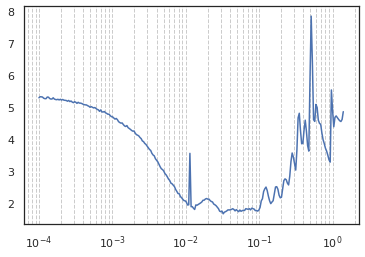

In [ ]:
plot_lr_vs_loss(rates, losses)

### Distance Learning

In [ ]:
!mkdir 70s

mkdir: cannot create directory ‘70s’: File exists


In [ ]:
train_percent = config.Sample_percent
val_percent = config.Sample_percent
int(train_percent*np.power(len(train_idx), 2)), int(val_percent*np.power(len(val_idx), 2))

(63101, 7022)

In [ ]:
#0.001 direct s2s2 geometry
model, history1 = train_siamese2(X=X, y=y, 
                               train_idx=train_idx, 
                               val_idx=val_idx,
                               config=config,
                               path_logs_training="70s", 
                               training_description="model_ctf_128_trail_1",
                               training_steps=int(train_percent*np.power(len(train_idx), 2)), 
                               validation_steps=int(val_percent*np.power(len(val_idx), 2)), 
                               plot=False,
                               gpus=None)

Data created in 4.202582359313965 sec
Data created in 0.4742312431335449 sec
Input images shape (128, 128, 1)
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_13 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_7 (Functional)           (None, 6)            5673094     ['input_12[0][0]

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Model will be saved to: 70s/training/model_ctf_128_trail_1.h5


wandb: WARNING Unable to compute FLOPs for this model.


Epoch 1/50
257/257 [==============================] - 149s 560ms/step - loss: 5.0758 - model_7_loss: 0.6625 - model_7_1_loss: 0.6637 - out_std: 0.1249 - val_loss: 4.8296 - val_model_7_loss: 0.6620 - val_model_7_1_loss: 0.6625 - val_out_std: 0.0043 - _timestamp: 1658735272.0000 - _runtime: 174.0000
Epoch 2/50
257/257 [==============================] - 143s 555ms/step - loss: 4.5341 - model_7_loss: 0.6466 - model_7_1_loss: 0.6471 - out_std: 0.2158 - val_loss: 4.3112 - val_model_7_loss: 0.6676 - val_model_7_1_loss: 0.6678 - val_out_std: 0.0033 - _timestamp: 1658735415.0000 - _runtime: 317.0000
Epoch 3/50
257/257 [==============================] - 143s 554ms/step - loss: 3.9692 - model_7_loss: 0.6047 - model_7_1_loss: 0.6060 - out_std: 0.3478 - val_loss: 3.8427 - val_model_7_loss: 0.6608 - val_model_7_1_loss: 0.6607 - val_out_std: 0.0289 - _timestamp: 1658735557.0000 - _runtime: 459.0000
Epoch 4/50
257/257 [==============================] - 143s 555ms/step - loss: 3.3392 - model_7_loss: 0.

In [ ]:
#0.001 direct s2s2 not geometry yet
model, history1 = train_siamese2(X=X, y=y, 
                               train_idx=train_idx, 
                               val_idx=val_idx,
                               epochs=50, 
                               batch_size=256, 
                               learning_rate=1e-3, 
                               limit_style="random",
                               path_logs_training="70s", 
                               training_description="model_ctf_prelu_256_drp0.3_batch_datagen_weight_sch_l2",
                               training_steps=int(train_percent*np.power(len(train_idx), 2)), 
                               validation_steps=int(val_percent*np.power(len(val_idx), 2)), 
                               plot=False,
                               gpus=None)

Data created in 6.161330938339233 sec
Data created in 0.4722418785095215 sec
Input images shape (130, 130, 1)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 130, 130, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 130, 130, 1  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 6)            5753514     ['input_1[0][0]'

### Read Model Checkpoint

In [ ]:
# put correct filename
model_filename = f"70s/training/model_ctf_prelu_256_drp0.3_batch_datagen_weight_sch_l2.h5"

# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename, compile=False, custom_objects={"BlurLayer": BlurLayer, "ActivationStdLoggingLayer":tfsim.layers.ActivationStdLoggingLayer})

# Show the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 130, 130, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 130, 130, 1  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 4)            5746276     ['input_1[0][0]',                
                                                                  'input_2[0][0]']          

### Performance Plot - True vs. Predicted

In [ ]:
def d_p(p1, p2):
    p1 = tf.cast(p1, dtype=tf.float32)
    p2 = tf.cast(p2, dtype=tf.float32)
    return model.predict([p1, p2], batch_size=256)

In [ ]:
cnn = model.layers[-1]

In [ ]:
q_pred_train = cnn.predict(X[train_idx])
q_pred_val = cnn.predict(X[val_idx])
q_pred_test = cnn.predict(X[test_idx])

q_pred_train = s2s2_to_SO3(q_pred_train)
q_pred_val = s2s2_to_SO3(q_pred_val)
q_pred_test = s2s2_to_SO3(q_pred_test)

q_pred_train = matrix2euler(q_pred_train)
q_pred_val = matrix2euler(q_pred_val)
q_pred_test = matrix2euler(q_pred_test)

q_pred_train = euler2quaternion(q_pred_train)
q_pred_val = euler2quaternion(q_pred_val)
q_pred_test = euler2quaternion(q_pred_test)

In [ ]:
#vgg s2s2
c1 = d_q(q_pred_train, euler2quaternion(matrix2euler(y[train_idx])))
c2 = d_q(q_pred_val, euler2quaternion(matrix2euler(y[val_idx])))
c3 = d_q(q_pred_test, euler2quaternion(matrix2euler(y[test_idx])))
np.median(c1), np.median(c2), np.median(c3), np.mean(c1), np.mean(c2), np.mean(c3)

In [ ]:
#vgg s2s2
c1 = d_q(q_pred_train, euler2quaternion(matrix2euler(y[train_idx])))
c2 = d_q(q_pred_val, euler2quaternion(matrix2euler(y[val_idx])))
c3 = d_q(q_pred_test, euler2quaternion(matrix2euler(y[test_idx])))
np.median(c1), np.median(c2), np.median(c3), np.mean(c1), np.mean(c2), np.mean(c3)

(0.017132129798720825,
 0.09057578664205262,
 0.09588816560730838,
 0.018489903251741425,
 0.10747442285195383,
 0.11183776300696069)

In [ ]:
#vgg s2s2
c1 = d_q(q_pred_train, euler2quaternion(matrix2euler(y[train_idx])))
c2 = d_q(q_pred_val, euler2quaternion(matrix2euler(y[val_idx])))
c3 = d_q(q_pred_test, euler2quaternion(matrix2euler(y[test_idx])))
np.median(c1), np.median(c2), np.median(c3), np.mean(c1), np.mean(c2), np.mean(c3)

(0.01279351439729858,
 0.09188174611836959,
 0.09040720639361685,
 0.01341554126055494,
 0.10605329208633768,
 0.1066608631911518)

In [ ]:
#vgg s2s2
c1 = d_q(q_pred_train, euler2quaternion(matrix2euler(y[train_idx])))
c2 = d_q(q_pred_val, euler2quaternion(matrix2euler(y[val_idx])))
c3 = d_q(q_pred_test, euler2quaternion(matrix2euler(y[test_idx])))
np.median(c1), np.median(c2), np.median(c3), np.mean(c1), np.mean(c2), np.mean(c3)

(0.013417479263435518,
 0.08880316841949948,
 0.09127584305562417,
 0.014140264786780344,
 0.10257083717558828,
 0.10539044985118708)

In [ ]:
#vgg s2s2
c1 = d_q(q_pred_train, euler2quaternion(matrix2euler(y[train_idx])))
c2 = d_q(q_pred_val, euler2quaternion(matrix2euler(y[val_idx])))
c3 = d_q(q_pred_test, euler2quaternion(matrix2euler(y[test_idx])))
np.median(c1), np.median(c2), np.median(c3), np.mean(c1), np.mean(c2), np.mean(c3)

(0.012567132101061316,
 0.08904806147371885,
 0.0883875416434675,
 0.013239881569252062,
 0.10171826708403434,
 0.10207171338993633)

In [ ]:
#vgg
c1 = d_q(q_pred_train, euler2quaternion(matrix2euler(y[train_idx])))
c2 = d_q(q_pred_val, euler2quaternion(matrix2euler(y[val_idx])))
c3 = d_q(q_pred_test, euler2quaternion(matrix2euler(y[test_idx])))
np.median(c1), np.median(c2), np.median(c3), np.mean(c1), np.mean(c2), np.mean(c3)

(0.018138336630475156,
 0.11030711266917842,
 0.10999474234344361,
 0.019203932928001967,
 0.13371548218382667,
 0.13879508635202692)

In [ ]:
#vgg
c1 = d_q(q_pred_train, euler2quaternion(matrix2euler(y[train_idx])))
c2 = d_q(q_pred_val, euler2quaternion(matrix2euler(y[val_idx])))
c3 = d_q(q_pred_test, euler2quaternion(matrix2euler(y[test_idx])))
np.median(c1), np.median(c2), np.median(c3), np.mean(c1), np.mean(c2), np.mean(c3)

(0.04561529354132983,
 0.1188536313214747,
 0.11902840067185028,
 0.046228753272818814,
 0.1422445411286099,
 0.1438789126831922)

In [ ]:
q_pred_train1 = cnn.predict(X[train_idx])[0]
q_pred_val1 = cnn.predict(X[val_idx])[0]
q_pred_test1 = cnn.predict(X[test_idx])[0]

In [ ]:
#vgg
c1 = d_q(q_pred_train1, matrix2quaternion(y[train_idx]))
c2 = d_q(q_pred_val1, matrix2quaternion(y[val_idx]))
c3 = d_q(q_pred_test1, matrix2quaternion(y[test_idx]))
np.median(c1), np.median(c2), np.median(c3)

(0.13844869857137915, 0.22222632136125334, 0.2265964950836427)

In [ ]:
from cryoem.conversions import matrix2euler

In [ ]:
q_pred_train = cnn.predict(X[train_idx])[1]
q_pred_val = cnn.predict(X[val_idx])[1]
q_pred_test = cnn.predict(X[test_idx])[1]

q_pred_train = s2s2_to_SO3(q_pred_train)
q_pred_val = s2s2_to_SO3(q_pred_val)
q_pred_test = s2s2_to_SO3(q_pred_test)

q_pred_train = matrix2euler(q_pred_train)
q_pred_val = matrix2euler(q_pred_val)
q_pred_test = matrix2euler(q_pred_test)

q_pred_train = euler2quaternion(q_pred_train)
q_pred_val = euler2quaternion(q_pred_val)
q_pred_test = euler2quaternion(q_pred_test)

In [ ]:
#vgg
c1 = d_q(q_pred_train, euler2quaternion(matrix2euler(y[train_idx])))
c2 = d_q(q_pred_val, euler2quaternion(matrix2euler(y[val_idx])))
c3 = d_q(q_pred_test, euler2quaternion(matrix2euler(y[test_idx])))
np.median(c1), np.median(c2), np.median(c3), np.mean(c1), np.mean(c2), np.mean(c3)

(0.013330720137407014,
 0.10061074334771139,
 0.10369546626951315,
 0.013999246731168714,
 0.12619904746790156,
 0.13135019944918627)

In [ ]:
q_pred_train1 = cnn.predict(X[train_idx])[0]
q_pred_val1 = cnn.predict(X[val_idx])[0]
q_pred_test1 = cnn.predict(X[test_idx])[0]

In [ ]:
yy = y[test_idx]
XX = X[test_idx]

idx1 = list(np.random.choice(np.arange(1650), size=5000))
idx2 = list(np.random.choice(np.arange(1650), size=5000))

q1_true = euler2quaternion([yy[i] for i in idx1])
q2_true = euler2quaternion([yy[i] for i in idx2])

p1 = [XX[i] for i in idx1]
p2 = [XX[i] for i in idx2]

aa = d_p(p1, p2)

dP_values = aa[0].squeeze().T
dQ_values = d_q(q1_true, q2_true).numpy()

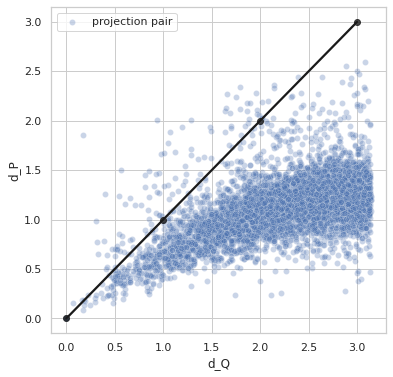

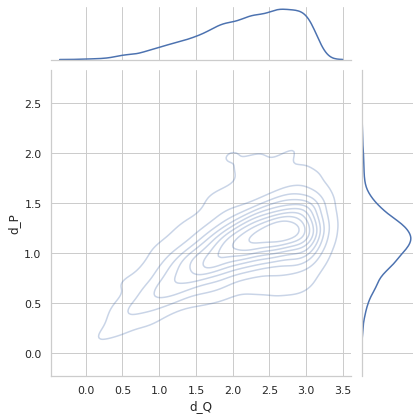

Variance = 1.2171454970413587
Min. angle recovery loss possible = 1.4811468723358627
MAE:  1.1020256


In [ ]:
plot_dP_dQ(dP_values, dQ_values)

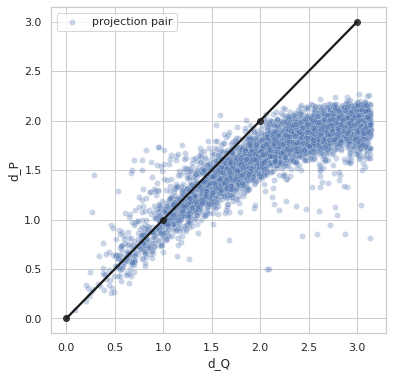

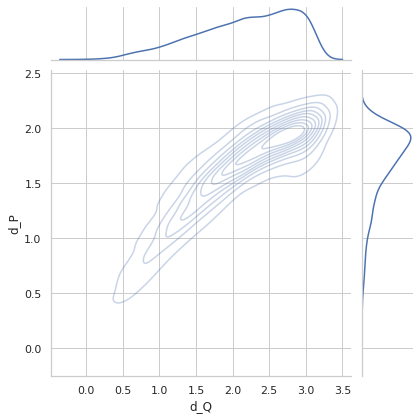

Variance = 0.6460625017546717
Min. angle recovery loss possible = 0.4173132768222705
MAE:  0.5441095


In [ ]:
plot_dP_dQ(dP_values, dQ_values)

In [ ]:
from cryoem.conversions import quaternion2euler, euler2matrix, matrix2euler

In [ ]:
qo = quaternion2euler(quaternion.normalize(q_pred_test)).numpy()

projections_filename = "70S_ctf.star"
s = Starfile.load(projections_filename)
df = s.df
df2 = df.iloc[test_idx].copy()
df2['_rlnAngleRot'] = (qo[:,2]/(2*np.pi)*360 +360)%360
df2['_rlnAngleTilt'] = qo[:,1]/(2*np.pi)*360 
df2['_rlnAnglePsi'] = (qo[:,0]/(2*np.pi)*360 +360)%360
df2['_rlnAngleRot'] = df2['_rlnAngleRot'].astype(str)
df2['_rlnAngleTilt'] = df2['_rlnAngleTilt'].astype(str)
df2['_rlnAnglePsi'] = df2['_rlnAnglePsi'].astype(str)

In [ ]:
df3 = df.iloc[test_idx].copy()
df3.head(50)

,_rlnAnglePsi,_rlnAngleRot,_rlnAngleTilt,_rlnImageName,_rlnOriginX,_rlnOriginY,_rlnDefocusU,_rlnDefocusV,_rlnDefocusAngle
8,81.197956,287.159142,97.699893,000009@70S_ctf.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
12,140.296601,124.073356,47.719116,000013@70S_ctf.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
14,220.758505,239.665568,82.987606,000015@70S_ctf.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
17,213.749399,342.627654,24.131180,000018@70S_ctf.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
19,327.190018,203.116672,73.805160,000020@70S_ctf.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
23,286.109583,158.803253,92.798070,000024@70S_ctf.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
26,29.663469,2.497110,58.325751,000027@70S_ctf.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
29,92.074603,82.645496,149.348155,000030@70S_ctf.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
30,71.919444,224.805894,155.095786,000031@70S_ctf.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
31,53.260254,74.851211,79.719329,000032@70S_ctf.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000


In [ ]:
df2.head(50)

,_rlnAnglePsi,_rlnAngleRot,_rlnAngleTilt,_rlnImageName,_rlnOriginX,_rlnOriginY,_rlnDefocusU,_rlnDefocusV,_rlnDefocusAngle
8,83.71332,286.41214,97.90521,000009@70S_ctf.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
12,138.83185,124.22919,55.142334,000013@70S_ctf.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
14,212.06847,239.93639,75.488976,000015@70S_ctf.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
17,218.41663,340.72708,22.480541,000018@70S_ctf.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
19,327.99353,193.89828,73.700806,000020@70S_ctf.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
23,290.99744,155.78204,86.22329,000024@70S_ctf.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
26,25.68164,5.63089,62.91239,000027@70S_ctf.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
29,17.384338,10.033752,163.81648,000030@70S_ctf.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
30,61.985474,220.53984,152.53592,000031@70S_ctf.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000
31,52.69165,71.49933,76.797455,000032@70S_ctf.mrcs,0.000000,0.000000,21580.000000,21580.000000,0.000000


In [ ]:
s2 = Starfile(df2.columns, df2)
s2.write('70s_new.star')

In [ ]:
df4 = df2.loc[:,'_rlnAnglePsi':'_rlnAngleTilt'].astype(float) - df3.loc[:,'_rlnAnglePsi':'_rlnAngleTilt'].astype(float)

In [ ]:
df4.head(50)

,_rlnAnglePsi,_rlnAngleRot,_rlnAngleTilt,_rlnAnglePsi_a,_rlnAngleRot_a,_rlnAngleTilt_a
8,2.515364,-0.747002,0.205317,2.515364,0.747002,0.205317
12,-1.464751,0.155834,7.423218,1.464751,0.155834,7.423218
14,-8.690035,0.270822,-7.498630,8.690035,0.270822,7.498630
17,4.667231,-1.900574,-1.650639,4.667231,1.900574,1.650639
19,0.803512,-9.218392,-0.104354,0.803512,9.218392,0.104354
23,4.887857,-3.021213,-6.574780,4.887857,3.021213,6.574780
26,-3.981829,3.133780,4.586639,3.981829,3.133780,4.586639
29,-74.690265,-72.611744,14.468325,74.690265,72.611744,14.468325
30,-9.933970,-4.266054,-2.559866,9.933970,4.266054,2.559866
31,-0.568604,-3.351881,-2.921874,0.568604,3.351881,2.921874


In [ ]:
a1 = df4['_rlnAnglePsi']%360
a2 = df4['_rlnAngleRot']%360
a3 = df4['_rlnAngleTilt']%180

In [ ]:
b1 = a1.values
b2 = a2.values
b3 = a3.values

In [ ]:
c1 = np.where(b1 <180, b1, 360-b1)
c2 = np.where(b2 <180, b2, 360-b2)
c3 = np.where(b3 <90, b3, 180-b3)  

In [ ]:
df4['_rlnAnglePsi_a'] = c1
df4['_rlnAngleRot_a'] = c2
df4['_rlnAngleTilt_a'] = c3

In [ ]:
df4.describe()

,_rlnAnglePsi,_rlnAngleRot,_rlnAngleTilt,_rlnAnglePsi_a,_rlnAngleRot_a,_rlnAngleTilt_a
count,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000
mean,-2.849754,-2.042284,0.273546,7.004892,9.706539,4.961735
std,49.343357,53.085736,10.636093,16.661152,18.601663,7.329550
min,-357.788591,-359.039705,-92.380234,0.000543,0.005602,0.000223
25%,-3.115465,-4.771998,-3.117591,1.264922,2.194440,1.487112
50%,-0.117898,-0.033229,0.157935,2.785635,4.762385,3.182549
75%,2.401084,4.863767,3.259405,5.580752,9.216463,5.809968
max,357.375193,358.041918,163.676132,176.935941,175.188485,89.329145
